# Projet 7 : Réalisez une analyse de sentiments grâce au Deep Learning
# Modèle sur mesure avancé

[Lien OpenClassroom](https://openclassrooms.com/fr/paths/795/projects/1516/1578-mission)

---

**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Chargement des données](#toc2_)    
- [Préparation pour Deep Leanring](#toc3_)    
  - [Création d'un Tokenizer](#toc3_1_)    
  - [Sauvegarde du Tokenizer](#toc3_2_)    
  - [Chargement de GloVe Embeddings](#toc3_3_)    
  - [Création du modèle](#toc3_4_)    
- [Experiment 1: LSTM avec GloVe Embeddings](#toc4_)    
  - [MLFlow Setup](#toc4_1_)    
  - [Entrainement du modèle avec MLFlow](#toc4_2_)    
- [Experiment 2: LSTM avec GloVe Embeddings (Entrainable)](#toc5_)    
  - [Entrainement du modèle avec MLFlow](#toc5_1_)    
- [Evaluation et Selection](#toc6_)    
  - [Selection du meilleur modèle (val_accuracy)](#toc6_1_)    
  - [Evaluation du modèle sur les données de Test](#toc6_2_)    
  - [Enregistrement du model](#toc6_3_)    
- [Dashboard MLFlow](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
---

## <a id='toc1_'></a>[Imports](#toc0_)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Embedding,
    Bidirectional,
    Input,
    SpatialDropout1D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import mlflow
import mlflow.tensorflow  # Essential for autologging
import pickle  # For saving the tokenizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import traceback

warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

---
---

## <a id='toc2_'></a>[Chargement des données](#toc0_)

In [2]:
TRAIN_DATA_PATH = "./train_data.csv"
VAL_DATA_PATH = "./validation_data.csv"
TEST_DATA_PATH = "./test_data.csv"

train_df = pd.read_csv(TRAIN_DATA_PATH)
val_df = pd.read_csv(VAL_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

# Handle potential NaN values in 'cleaned_text' that might result from preprocessing
train_df["cleaned_text"].fillna("", inplace=True)
val_df["cleaned_text"].fillna("", inplace=True)
test_df["cleaned_text"].fillna("", inplace=True)


X_train = train_df["cleaned_text"]
y_train = train_df["sentiment"].replace({"negative": 0, "positive": 1}).astype(int)
X_val = val_df["cleaned_text"]
y_val = val_df["sentiment"].replace({"negative": 0, "positive": 1}).astype(int)
X_test = test_df["cleaned_text"]
y_test = test_df["sentiment"].replace({"negative": 0, "positive": 1}).astype(int)

print("Data loaded successfully:")
print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Data loaded successfully:
Train samples: 1114106
Validation samples: 238737
Test samples: 238738


---
---

## <a id='toc3_'></a>[Préparation pour Deep Leanring](#toc0_)

---

### <a id='toc3_1_'></a>[Création d'un Tokenizer](#toc0_)

In [3]:
VOCAB_SIZE = 200
MAX_SEQUENCE_LENGTH = 20

tokenizer = Tokenizer(
    num_words=VOCAB_SIZE, oov_token="<OOV>"
)  # OOV token for out-of-vocabulary words

# Fit the tokenizer ONLY on the training data
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(
    X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
)
X_val_pad = pad_sequences(
    X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
)
X_test_pad = pad_sequences(
    X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
)

# Vocabulary size for the embedding layer (add 1 for the padding token 0)
# Use min to handle cases where actual vocab is smaller than VOCAB_SIZE
actual_vocab_size = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)
print(f"Actual vocabulary size used: {actual_vocab_size}")
print(f"Shape of padded training sequences: {X_train_pad.shape}")
print(f"Shape of padded validation sequences: {X_val_pad.shape}")
print(f"Shape of padded test sequences: {X_test_pad.shape}")

Actual vocabulary size used: 200
Shape of padded training sequences: (1114106, 20)
Shape of padded validation sequences: (238737, 20)
Shape of padded test sequences: (238738, 20)


---

### <a id='toc3_2_'></a>[Sauvegarde du Tokenizer](#toc0_)

In [4]:
with open("keras_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

---

### <a id='toc3_3_'></a>[Chargement de GloVe Embeddings](#toc0_)

In [7]:
GLOVE_PATH = "./glove.6B.300d.txt"
EMBEDDING_DIM = 300

embeddings_index = {}
try:
    with open(GLOVE_PATH, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors in {GLOVE_PATH}.")
except FileNotFoundError:
    print(f"Error: GloVe file not found at {GLOVE_PATH}")
    print("Skipping GloVe experiment.")
    embeddings_index = None  # Ensure variable exists but is None
except Exception as e:
    print(f"An error occurred loading GloVe file: {e}")
    embeddings_index = None

embedding_matrix = None
if embeddings_index:
    print("Creating embedding matrix...")
    # Initialize matrix with zeros
    embedding_matrix = np.zeros((actual_vocab_size, EMBEDDING_DIM))
    hits = 0
    misses = 0
    # Populate the matrix with GloVe vectors for words in our tokenizer's vocabulary
    for word, i in tokenizer.word_index.items():
        if i >= actual_vocab_size:  # Skip words beyond our vocab size limit
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print(f"Converted {hits} words ({misses} misses)")
    print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Found 400001 word vectors in ./glove.6B.300d.txt.
Creating embedding matrix...
Converted 198 words (1 misses)
Shape of embedding matrix: (200, 300)


---

### <a id='toc3_4_'></a>[Création du modèle](#toc0_)

In [ ]:
def build_lstm_model(
    vocab_size,
    embedding_dim,
    max_length,
    lstm_units,
    learning_rate,
    dropout_rate,
    embedding_matrix=None,
    is_embedding_trainable=False,
):

    model = Sequential()

    model.add(Input(shape=(max_length,)))

    if embedding_matrix is not None:
        print("Using pre-trained embedding matrix.")
        model.add(
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_length,
                trainable=is_embedding_trainable,
            )
        )
    else:
        print("Using trainable embedding layer.")
        model.add(
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                input_length=max_length,
                trainable=is_embedding_trainable,
            )
        )

    model.add(SpatialDropout1D(dropout_rate))

    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))

    model.add(Dense(1, activation="sigmoid"))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print("\nOptimized Model Summary:")
    model.summary()
    return model

---
---

## <a id='toc4_'></a>[Experiment 1: LSTM avec GloVe Embeddings](#toc0_)

---

### <a id='toc4_1_'></a>[MLFlow Setup](#toc0_)

In [5]:
EXPERIMENT_NAME = "Tweet Sentiment Analysis - Advanced DL"
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow experiment set to: '{EXPERIMENT_NAME}'")

MLflow experiment set to: 'Tweet Sentiment Analysis - Advanced DL'


---

### <a id='toc4_2_'></a>[Entrainement du modèle avec MLFlow](#toc0_)

In [ ]:
LSTM_UNITS = 32
LEARNING_RATE = 0.01
EPOCHS = 20
BATCH_SIZE = 512
DROPOUT = 0.2

TOKENIZER_ARTIFACT_PATH = "tokenizer"

MODEL_ARTIFACT_PATH = "model"

run_name_glove = "LSTM_GloVe_Embeddings"


print(f"\n--- Starting MLflow Run for: {run_name_glove} ---")


mlflow.tensorflow.autolog(
    log_models=True, disable=False, registered_model_name=None
)  # Disable registration via autolog for now


with mlflow.start_run(run_name=run_name_glove) as run_glove:

    run_id_glove = run_glove.info.run_id

    print(f"MLflow Run ID (GloVe): {run_id_glove}")

    # --- Log additional parameters manually (autolog might miss some) ---

    mlflow.log_param("embedding_type", "GloVe (Not Trainable)")

    mlflow.log_param("vocab_size", actual_vocab_size)

    mlflow.log_param("max_sequence_length", 300)

    mlflow.log_param("embedding_dim", EMBEDDING_DIM)

    mlflow.log_param("lstm_units", LSTM_UNITS)

    mlflow.log_param("dropout", DROPOUT)

    mlflow.log_param("learning_rate", LEARNING_RATE)

    mlflow.log_param("epochs", EPOCHS)

    mlflow.log_param("batch_size", BATCH_SIZE)

    mlflow.log_param("architecture", "Input-Embedding-SpatialDropout-BiLSTM-Dense")

    # --- Build the model ---

    model_glove = build_lstm_model(
        vocab_size=actual_vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=300,
        lstm_units=LSTM_UNITS,
        dropout_rate=DROPOUT,
        learning_rate=LEARNING_RATE,
        embedding_matrix=embedding_matrix,
    )

    # --- Callbacks ---

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

    # --- Train the model ---

    print("\nTraining LSTM model with GloVe embeddings...")

    history_glove = model_glove.fit(
        X_train_pad,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping],
        verbose=2,
    )

    print("GloVe Model Training Finished.")

    if os.path.exists("keras_tokenizer.pkl"):

        mlflow.log_artifact(
            "keras_tokenizer.pkl", artifact_path=TOKENIZER_ARTIFACT_PATH
        )

        print(f"Tokenizer logged as artifact to MLflow run {run_id_glove}.")

    else:
        print(
            "Warning: Tokenizer file keras_tokenizer.pkl not found, could not log artifact."
        )

    print(f"--- MLflow Run {run_id_glove} finished ---")


--- Starting MLflow Run for: LSTM_GloVe_Embeddings ---
MLflow Run ID (GloVe): 731f586d05894dd881526bb0771dfe6c
Using pre-trained embedding matrix.

Optimized Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 300)       │        60,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 300, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,657 (401.00 KB)

 Trainable params: 42,657 (166.63 KB)

 Non-trainable params: 60,000 (234.38 KB)

2025/05/23 11:14:35 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Training LSTM model with GloVe embeddings...


Epoch 1/20


2176/2176 - 32s - 15ms/step - accuracy: 0.6988 - loss: 0.5652 - val_accuracy: 0.7134 - val_loss: 0.5464
Epoch 2/20


2176/2176 - 29s - 13ms/step - accuracy: 0.7103 - loss: 0.5488 - val_accuracy: 0.7138 - val_loss: 0.5422
Epoch 3/20


2176/2176 - 30s - 14ms/step - accuracy: 0.7118 - loss: 0.5456 - val_accuracy: 0.7148 - val_loss: 0.5421
Epoch 4/20


2176/2176 - 29s - 13ms/step - accuracy: 0.7130 - loss: 0.5442 - val_accuracy: 0.7151 - val_loss: 0.5405
Epoch 5/20
2176/2176 - 29s - 13ms/step - accuracy: 0.7139 - loss: 0.5432 - val_accuracy: 0.7147 - val_loss: 0.5426
Epoch 6/20
2176/2176 - 29s - 13ms/step - accuracy: 0.7141 - loss: 0.5422 - val_accuracy: 0.7165 - val_loss: 0.5407
Epoch 7/20


2176/2176 - 29s - 13ms/step - accuracy: 0.7144 - loss: 0.5418 - val_accuracy: 0.7170 - val_loss: 0.5388
Epoch 8/20


2176/2176 - 29s - 13ms/step - accuracy: 0.7150 - loss: 0.5412 - val_accuracy: 0.7169 - val_loss: 0.5387
Epoch 9/20
2176/2176 - 29s - 13ms/step - accuracy: 0.7151 - loss: 0.5406 - val_accuracy: 0.7169 - val_loss: 0.5392
Epoch 10/20
2176/2176 - 30s - 14ms/step - accuracy: 0.7156 - loss: 0.5403 - val_accuracy: 0.7178 - val_loss: 0.5389
Epoch 11/20
2176/2176 - 29s - 13ms/step - accuracy: 0.7156 - loss: 0.5400 - val_accuracy: 0.7173 - val_loss: 0.5387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
GloVe Model Training Finished.
Tokenizer logged as artifact to MLflow run 731f586d05894dd881526bb0771dfe6c.
--- MLflow Run 731f586d05894dd881526bb0771dfe6c finished ---


---
---

## <a id='toc5_'></a>[Experiment 2: LSTM avec GloVe Embeddings (Entrainable)](#toc0_)

---

### <a id='toc5_1_'></a>[Entrainement du modèle avec MLFlow](#toc0_)

In [10]:
LSTM_UNITS = 100
LEARNING_RATE = 0.01
EPOCHS = 20
BATCH_SIZE = 256
DROPOUT = 0.2

TOKENIZER_ARTIFACT_PATH = "tokenizer"


MODEL_ARTIFACT_PATH = "model"


run_name_trainable = "LSTM_Trainable_Embeddings"


print(f"\n--- Starting MLflow Run for: {run_name_trainable } ---")


mlflow.tensorflow.autolog(
    log_models=True, disable=False, registered_model_name=None
)  # Disable registration via autolog for now


with mlflow.start_run(run_name=run_name_trainable) as run_trainable:

    run_id_trainable = run_trainable.info.run_id
    print(f"MLflow Run ID (Trainable): {run_id_trainable}")

    # --- Log additional parameters manually (autolog might miss some) ---

    mlflow.log_param("embedding_type", "GloVe (Not Trainable)")

    mlflow.log_param("vocab_size", actual_vocab_size)

    mlflow.log_param("max_sequence_length", 300)

    mlflow.log_param("embedding_dim", EMBEDDING_DIM)

    mlflow.log_param("lstm_units", LSTM_UNITS)

    mlflow.log_param("dropout", DROPOUT)

    mlflow.log_param("learning_rate", LEARNING_RATE)

    mlflow.log_param("epochs", EPOCHS)

    mlflow.log_param("batch_size", BATCH_SIZE)

    mlflow.log_param("architecture", "Input-Embedding-SpatialDropout-BiLSTM-Dense")

    # --- Build the model ---

    model_glove = build_lstm_model(
        vocab_size=actual_vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=300,
        lstm_units=LSTM_UNITS,
        dropout_rate=DROPOUT,
        learning_rate=LEARNING_RATE,
        embedding_matrix=None,
        is_embedding_trainable=True,
    )

    # --- Callbacks ---

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

    # --- Train the model ---

    print("\nTraining LSTM model with GloVe embeddings...")

    history_glove = model_glove.fit(
        X_train_pad,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping],
        verbose=2,
    )

    print("GloVe Model Training Finished.")

    if os.path.exists("keras_tokenizer.pkl"):

        mlflow.log_artifact(
            "keras_tokenizer.pkl", artifact_path=TOKENIZER_ARTIFACT_PATH
        )

        print(f"Tokenizer logged as artifact to MLflow run {run_id_glove}.")

    else:
        print(
            "Warning: Tokenizer file keras_tokenizer.pkl not found, could not log artifact."
        )

    print(f"--- MLflow Run {run_id_glove} finished ---")


--- Starting MLflow Run for: LSTM_Trainable_Embeddings ---
MLflow Run ID (Trainable): 8009843fc9b94803a63e23d56615957e
Using trainable embedding layer.

Optimized Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 300, 300)       │        60,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 300, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,501 (861.33 KB)

 Trainable params: 220,501 (861.33 KB)

 Non-trainable params: 0 (0.00 B)

2025/05/23 11:25:09 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Training LSTM model with GloVe embeddings...


Epoch 1/20


4352/4352 - 95s - 22ms/step - accuracy: 0.6970 - loss: 0.5600 - val_accuracy: 0.7121 - val_loss: 0.5440
Epoch 2/20


4352/4352 - 91s - 21ms/step - accuracy: 0.7128 - loss: 0.5422 - val_accuracy: 0.7124 - val_loss: 0.5427
Epoch 3/20


4352/4352 - 91s - 21ms/step - accuracy: 0.7147 - loss: 0.5397 - val_accuracy: 0.7161 - val_loss: 0.5382
Epoch 4/20


4352/4352 - 91s - 21ms/step - accuracy: 0.7155 - loss: 0.5382 - val_accuracy: 0.7164 - val_loss: 0.5379
Epoch 5/20


4352/4352 - 91s - 21ms/step - accuracy: 0.7158 - loss: 0.5377 - val_accuracy: 0.7164 - val_loss: 0.5377
Epoch 6/20
4352/4352 - 91s - 21ms/step - accuracy: 0.7160 - loss: 0.5375 - val_accuracy: 0.7167 - val_loss: 0.5379
Epoch 7/20
4352/4352 - 90s - 21ms/step - accuracy: 0.7158 - loss: 0.5375 - val_accuracy: 0.7169 - val_loss: 0.5380
Epoch 8/20
4352/4352 - 91s - 21ms/step - accuracy: 0.7159 - loss: 0.5381 - val_accuracy: 0.7160 - val_loss: 0.5397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
GloVe Model Training Finished.
Tokenizer logged as artifact to MLflow run 731f586d05894dd881526bb0771dfe6c.
--- MLflow Run 731f586d05894dd881526bb0771dfe6c finished ---


---
---

## <a id='toc6_'></a>[Evaluation et Selection](#toc0_)

---

### <a id='toc6_1_'></a>[Selection du meilleur modèle (val_accuracy)](#toc0_)

In [13]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    filter_string="metrics.val_accuracy > 0",
    order_by=["metrics.val_accuracy DESC"],
    max_results=1,
)
BEST_RUN_ID = runs[0].info.run_id
print(f"Automatically selected best run based on val_accuracy: {BEST_RUN_ID}")
print(f"Selected model type: {runs[0].data.params.get('embedding_type')}")

Automatically selected best run based on val_accuracy: b72ca14fe64c4a549306aebe1ba4641c
Selected model type: Trainable


---

### <a id='toc6_2_'></a>[Evaluation du modèle sur les données de Test](#toc0_)


--- Evaluating Best Model (Run ID: b72ca14fe64c4a549306aebe1ba4641c) on Test Set ---


Tokenizer loaded successfully from artifact.
Best model loaded successfully from: runs:/b72ca14fe64c4a549306aebe1ba4641c/model

Predicting on test set...
Test Loss: 0.5298
Test Accuracy: 0.7211
7461/7461 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Test Precision: 0.6990
Test Recall: 0.7759
Test F1-Score: 0.7355

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.67      0.71    119443
           1       0.70      0.78      0.74    119295

    accuracy                           0.72    238738
   macro avg       0.72      0.72      0.72    238738
weighted avg       0.72      0.72      0.72    238738


Confusion Matrix (Test Set):


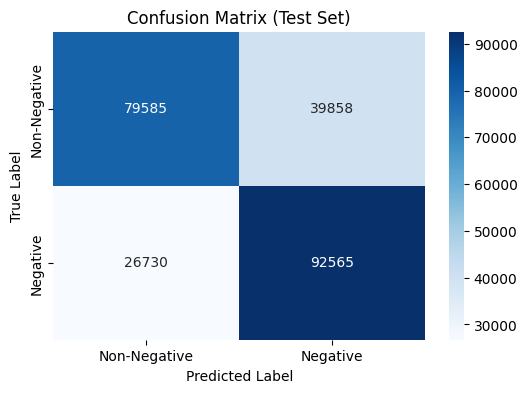


Test metrics logged back to the selected MLflow run.


<Figure size 640x480 with 0 Axes>

In [32]:
print(f"\n--- Evaluating Best Model (Run ID: {BEST_RUN_ID}) on Test Set ---")

# --- Load Tokenizer ---
try:
    client = mlflow.tracking.MlflowClient()
    # Download the tokenizer artifact logged in the best run
    local_path = client.download_artifacts(BEST_RUN_ID, TOKENIZER_ARTIFACT_PATH, ".")
    tokenizer_path = os.path.join(local_path, "keras_tokenizer.pkl")
    with open(tokenizer_path, "rb") as handle:
        loaded_tokenizer = pickle.load(handle)
    print("Tokenizer loaded successfully from artifact.")

    # Preprocess test data *using the loaded tokenizer* (already done above, but good practice)
    # X_test_seq_loaded = loaded_tokenizer.texts_to_sequences(X_test)
    # X_test_pad_loaded = pad_sequences(X_test_seq_loaded, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    # Using X_test_pad calculated earlier which used the correct tokenizer
    X_test_pad_loaded = X_test_pad

except Exception as e:
    print(
        f"Error loading tokenizer artifact for run {BEST_RUN_ID}: {traceback.format_exc()}"
    )
    print("Cannot proceed with test set evaluation without the correct tokenizer.")
    loaded_tokenizer = None  # Ensure it's None if loading fails

# --- Load Model ---
if loaded_tokenizer:  # Proceed only if tokenizer was loaded
    try:
        # Construct model URI
        model_uri = f"runs:/{BEST_RUN_ID}/{MODEL_ARTIFACT_PATH}"
        loaded_model = mlflow.tensorflow.load_model(model_uri)
        print(f"Best model loaded successfully from: {model_uri}")

        # --- Evaluate on Test Set ---
        print("\nPredicting on test set...")
        loss, accuracy = loaded_model.evaluate(X_test_pad_loaded, y_test, verbose=0)
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")

        # Get detailed predictions for other metrics
        y_pred_proba = loaded_model.predict(X_test_pad_loaded)
        y_pred = (
            (y_pred_proba > 0.5).astype(int).flatten()
        )  # Convert probabilities to binary predictions (0 or 1)

        test_precision = precision_score(y_test, y_pred, zero_division=0)
        test_recall = recall_score(y_test, y_pred, zero_division=0)
        test_f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")

        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix (Test Set):")
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Non-Negative", "Negative"],
            yticklabels=["Non-Negative", "Negative"],
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix (Test Set)")
        plt.show()

        # --- Optional: Log test metrics back to the selected run ---
        client.log_metric(BEST_RUN_ID, "test_loss", loss)
        client.log_metric(BEST_RUN_ID, "test_accuracy", accuracy)
        client.log_metric(BEST_RUN_ID, "test_precision", test_precision)
        client.log_metric(BEST_RUN_ID, "test_recall", test_recall)
        client.log_metric(BEST_RUN_ID, "test_f1", test_f1)
        print("\nTest metrics logged back to the selected MLflow run.")

        # Log confusion matrix image
        fig_path = "test_confusion_matrix.png"
        plt.savefig(fig_path)
        client.log_artifact(BEST_RUN_ID, fig_path)
        if os.path.exists(fig_path):
            os.remove(fig_path)

    except Exception as e:
        print(
            f"Error loading model or evaluating on test set for run {BEST_RUN_ID}: {traceback.format_exc()}"
        )

---

### <a id='toc6_3_'></a>[Enregistrement du model](#toc0_)

In [33]:
registered_model_info = mlflow.register_model(
    model_uri=f"runs:/{BEST_RUN_ID}/model", name="MODEL_ADVANCED"
)
print("Model registered successfully:")
print(f"- Name: {registered_model_info.name}")
print(f"- Version: {registered_model_info.version}")
print(f"- Stage: {registered_model_info.current_stage}")

Model registered successfully:
- Name: MODEL_ADVANCED
- Version: 1
- Stage: None


Successfully registered model 'MODEL_ADVANCED'.
Created version '1' of model 'MODEL_ADVANCED'.


---
---

## <a id='toc7_'></a>[Dashboard MLFlow](#toc0_)

In [ ]:
! mlflow server --host 127.0.0.1 --port 8080

![Overview](./mlflow_screenshot/advanced/Overview.png)

![Metrics](./mlflow_screenshot/advanced/Metrics.png)